# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

## Задача из статьи

Реализуем задачу с фасадами зданий (ссылка на статью: https://arxiv.org/pdf/1611.07004.pdf). Для построения генератора использовалась архитектура Unet (модель Unet реализована мною по архитектуре из лекций для задачи Semantic segmentation с небольшими дополнениями). В качестве модели дискриминатора авторы статьи использовали комбинацию convolution-BatchNorm-ReLu, поэтому была построена модель из данной комбинации с добавлением линейных слоев

In [127]:
#!pip install Pillow
import PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path

Так как Google Colab ввел мне ограничения, то пришлось экстренно переписать все для Jupyter Notebook. Некоторые строчки для работы в Google Colab закоменчены

In [128]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
import os
#!unzip data.zip

Выгружаем картинки (dataset с фасадами прошлось скачать)

In [129]:
train_dir = Path("data/facades/train")
test_dir = Path("data/facades/test")
train_a = sorted(list(train_dir.rglob('a/*.png')))
train_b = sorted(list(train_dir.rglob('b/*.png')))
test_a = sorted(list(test_dir.rglob('a/*.png')))
test_b = sorted(list(test_dir.rglob('b/*.png')))

print(len(train_a))

400


In [130]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pickle
from skimage import io
class Dataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files):
        super().__init__()
        self.files = sorted(files)
        self.len_ = len(self.files)
     
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 256, dtype='float32')
        x = transform1(x)
        return x
        
        
    def _prepare_sample(self, image):
        image = image.resize((256, 256))
        return np.array(image)

Ниже необходимый код для корректной работы GPU на Colab

In [131]:
#from os.path import exists
#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
#!pip install torch==1.7.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [132]:
!nvidia-smi
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Sun Jan 17 16:21:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 451.67       Driver Version: 451.67       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8     2W /  N/A |   1966MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

Выше был реализован класс Dataset для предобработки картинок (перевод в тензоры и изменение размеров картинок к одному размеру 256 \Times 256)

In [166]:
train = []
train.append(train_b)
train.append(train_a)
test = []
test.append(test_b)
test.append(test_a)
train_torch_a = Dataset(train_a)
train_torch_b = Dataset(train_b)
test_torch_a = Dataset(test_a)
test_torch_b = Dataset(test_b)
train_torch = Dataset(train)
test_torch = Dataset(test)

Следующая функция нужна для отрисовки картинок (данная функция из домашнего задания Классификация Симпсонов)

In [167]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

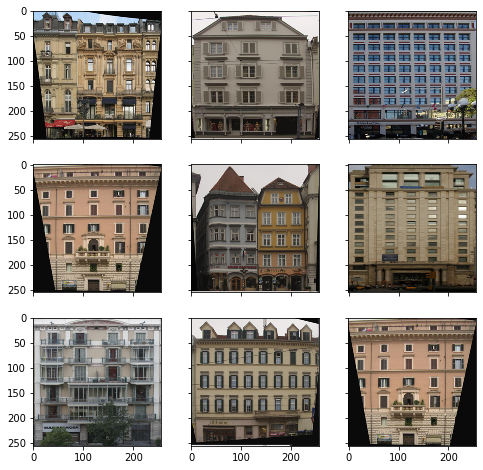

In [168]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val = train_torch_a[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

Объединяем "контуры" фасадов и реальные изображения и разбиваем на батчи

In [169]:
from torch.utils.data import DataLoader
batch_size = 25

data_tr = DataLoader(list(zip(train_torch_b, train_torch_a)), 
                     batch_size=batch_size, shuffle=False)
data_te = DataLoader(list(zip(test_torch_b, test_torch_a)), 
                     batch_size=batch_size, shuffle=False)

Модель Unet генератора

In [170]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1,
                      stride=2),# 256 -> 128
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            )
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1,
                      stride=2),# 128 -> 64
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.2),
            nn.ReLU(),
            )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,
                      stride=2), # 64 -> 32
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.2),
            nn.ReLU(),
            )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,
                      stride=2),# 32 -> 16
            nn.BatchNorm2d(64),
            nn.Dropout(p = 0.2),
            nn.ReLU(),
            )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
            ) 

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.BatchNorm2d(32),
            nn.Dropout(p = 0.2),
            nn.ReLU()
            )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.BatchNorm2d(16),
            nn.Dropout(p = 0.2),
            nn.ReLU()
            )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.BatchNorm2d(8),
            nn.ReLU()
            )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 128 -> 256
            )

    def forward(self, x):
        #print('Зашел в Unet')
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b+e3)
        d1 = self.upsample1(d0+e2)
        d2 = self.upsample2(d1+e1)
        d3 = self.upsample3(d2+e0)
        return d3

Модель Simple дискриминатора, после линейных слоев добавляем слой nn.Sigmoid(), чтобы дискриминатор выдавал числа от 0 до 1. Также используем .mean(dim=[1,2,3]) (усредняем по 1, 2 и 3 размерностям), чтобы получить одно число для одного изображения.

In [171]:
class Simple(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, padding=1,
                      stride=2),# 256 -> 128
            nn.BatchNorm2d(10), 
            nn.ReLU(),
            )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=1,
                      stride=2),# 128 -> 64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1,
                      stride=2), # 64 -> 32
            nn.BatchNorm2d(20),
            nn.ReLU(),
            )

        
        
        self.out1 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid())
        self.out1 = nn.Sigmoid()
        
    def forward(self, x):
        #print('Зашел в Simple')
        e0 = self.conv0(x)
        e1 = self.conv1(e0)
        e2 = self.conv2(e1)
        e3 = self.out1(e2)
        return e3.mean(dim=[1,2,3])

Обычная функция train, только для pix2pix у нам 2 модели, поэтому обучаем по батчам модель генератора, подавая на вход "контуров" фасадов и шум (z). Далее объединяем сгенеренные картинки и "контуры" фасадов по 1 размерности (было у "контуров" фасадов и сгенеренных картинок по 3 канала, после объединения будет 6 каналов), аналогично делаем с реальными кантинками и "контурами" фасадов, чтобы на вход дискриминатору подать не только реальные и сгенеренные картинки, но и "контуры" фасадов, как описано в статье. Объединяем эти картинки в батч. Так как дискриминатор обучается проще, то будем обучать его раз в 15 эпох.

In [172]:
def train(model_1, model_2, opt_1, opt_2, lossG, lossD, epochs, data_tr):
    history = []
    X_tra, Y_tra = next(iter(data_tr))
    for epoch in range(epochs):
        tic = time()
        train_loss = 0
        model_1.train()  # train mode
        model_2.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)

            opt_1.zero_grad()
            opt_2.zero_grad()
            z = torch.rand((X_batch.shape[0], 1, 256, 256)).to(DEVICE)

            Y_predG = model_1(X_batch + z)
            Y_predG_and_b = torch.cat((Y_predG, X_batch), dim=1)
            Ya_and_b = torch.cat((Y_batch, X_batch), dim=1)
            Y_predG_and_a = torch.cat((Y_predG_and_b, Ya_and_b), dim=0)
        
            Y_predD = model_2(Y_predG_and_a)
            loss_G = lossG(Y_predD.to(DEVICE), Y_predG.to(DEVICE), Y_batch.to(DEVICE)) # forward-pass my
            loss_G.backward()
            opt_1.step()
            train_loss += loss_G.cpu().detach().numpy() / len(X_batch)

            if epoch % 15 == 0:
                Y_predG = model_1(X_batch)
                Y_predG_and_b = torch.cat((Y_predG, X_batch), dim=1)
                Ya_and_b = torch.cat((Y_batch, X_batch), dim=1)
                Y_predG_and_a = torch.cat((Y_predG_and_b, Ya_and_b), dim=0)

                Y_predD = model_2(Y_predG_and_a)

                loss_D = -lossD(Y_predD.to(DEVICE), Y_predG.detach().to(DEVICE), Y_batch.to(DEVICE)) # forward-pass my
                opt_2.zero_grad()
                loss_D.backward()
                opt_2.step()
        print('Loss_D  %f' % loss_D)
        #train_loss_D += loss.cpu().detach().numpy() / len(X_batch)
        toc = time()

        history.append((train_loss))

        clear_output(wait=True)
        for k in range(1):
            plt.subplot(1, 2, k+1)
            imshow(Y_batch[k+11].cpu())
            plt.title('Real')
            #plt.axis('off')

            plt.subplot(1, 2, k+2)
            imshow(Y_predG[k+11].cpu().detach())
            plt.title('Output')
            #plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
    return history

Ниже реализована loss функция из статьи: $GAN_{loss} + \lambda L_1$. Лучшим параметром оказалась $\lambda \sim 10$

In [173]:
def lossG(y_predD, y_predG, Y_batch):
    y_predD_G = y_predD[:25]
    y_predD_D = y_predD[25:]
    loss = nn.L1Loss()
    output = loss(y_predG, Y_batch)
    res = 0.04*(torch.log(y_predD_D+1e-8) + torch.log(1-y_predD_G+1e-8)).sum() + 10 * output.sum()
    return res

Обучение на 500 эпохах (при обучении на 1000 эпохах результат получался хуже, чем на 500 эпохах)

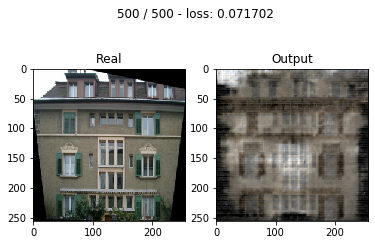

In [174]:
DEVICE = torch.device("cuda")
model_1 = UNet2().to(DEVICE)
model_2 = Simple().to(DEVICE)
optim_1 = optim.Adam(model_1.parameters(), lr=3e-3, weight_decay=0.001)
optim_2 = optim.Adam(model_2.parameters(), lr=3e-3, weight_decay=0.001)
train_1 = train(model_1, model_2, optim_1, optim_2, lossG, lossG, 500, data_tr)

In [145]:
from time import time
from IPython.display import clear_output

## Моя задача

Теперь попробуем реализовать задачу превращения черно-белого изображения в цветное для цветов роз. Используем датасет https://www.kaggle.com/alxmamaev/flowers-recognition раздел с розами. Данный датасет состоит только из цветных картинок разного размера, поэтому при помощи convert из PIL делаем изображения черно-белыми.

In [253]:
train_dir = Path("rose")
train_rose = sorted(list(train_dir.rglob('*.jpg')))
train_f = Dataset(train_rose)

Посмотрим на картинки

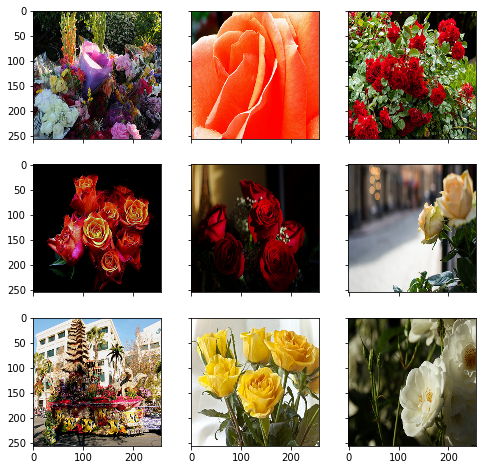

In [150]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val = train_f[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

Чтобы отработала нижняя строчка в Colab необходимо в директории создать папку BaW (Black and White), туда сохранятся черно-белые картинки

In [254]:
path = "rose/"
os.listdir(path)
for i in os.listdir(path):
    img = Image.open(path+i).convert('LA')
    img.save('BaW/'+i[:-3]+'png')

In [294]:
train_dir_baw = Path("BaW")
train_baw = sorted(list(train_dir_baw.rglob('*.png')))
train_f_baw = Dataset(train_baw)
train_data = DataLoader(list(zip(train_f_baw, train_f)), 
                        batch_size=25, shuffle=False)

Меняем число входных каналов модели, так как .convert('LA') сделал картинки 2 канальными. Также были убраны все dropout, потому что это повлияет на сгенерированное изображени, а именно на границы контуров объектов внутри изображения: они становятся менее четкими при включенном дропауте.

In [296]:
class UNet2_f(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, padding=1,
                      stride=2),# 256 -> 128
            nn.BatchNorm2d(8), 
            nn.ReLU(),
            )
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1,
                      stride=2),# 128 -> 64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            )
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1,
                      stride=2), # 64 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,
                      stride=2),# 32 -> 16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
            ) 

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU()
            )

        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.BatchNorm2d(16),
            nn.ReLU()
            )

        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.BatchNorm2d(8),
            nn.ReLU()
            )

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3,
                               stride=2, padding=1, output_padding=1), # 128 -> 256
            )

    def forward(self, x):
        #print('Зашел в Unet')
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(e0)
        e2 = self.enc_conv2(e1)
        e3 = self.enc_conv3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b+e3)
        d1 = self.upsample1(d0+e2)
        d2 = self.upsample2(d1+e1)
        d3 = self.upsample3(d2+e0)
        return d3

В модели дискриминатора меняем число входных каналов, потому что после объединения черно-белых картинок (2 канала) с цветными или сгенерированными (3 канала) по каналам будет 5 каналов

In [297]:
class Simple_f(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1,
                      stride=2),# 256 -> 128
            nn.BatchNorm2d(10), 
            nn.ReLU(),
            )
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=1,
                      stride=2),# 128 -> 64
            nn.BatchNorm2d(16),
            nn.ReLU(),
            )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1,
                      stride=2), # 64 -> 32
            nn.BatchNorm2d(20),
            nn.ReLU(),
            )

        
        
        self.out1 = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid())
        self.out1 = nn.Sigmoid()
        
    def forward(self, x):
        #print('Зашел в Simple')
        e0 = self.conv0(x)
        e1 = self.conv1(e0)
        e2 = self.conv2(e1)
        e3 = self.out1(e2)
        return e3.mean(dim=[1,2,3])

In [284]:
def train(model_1, model_2, opt_1, opt_2, lossG, lossD, epochs, data_tr):
    history = []
    X_tra, Y_tra = next(iter(data_tr))
    loss_D = []
    for epoch in range(epochs):
        tic = time()
        train_loss = 0
        model_1.train()  # train mode
        model_2.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            z = torch.rand((X_batch.shape[0], 1, 256, 256)).to(DEVICE)

            opt_1.zero_grad()
            opt_2.zero_grad()

            Y_predG = model_1(X_batch+z)
            Y_predG_and_b = torch.cat((Y_predG, X_batch), dim=1)
            Ya_and_b = torch.cat((Y_batch, X_batch), dim=1)
            Y_predG_and_a = torch.cat((Y_predG_and_b, Ya_and_b), dim=0)

            Y_predD = model_2(Y_predG_and_a)
            loss_G = lossG(Y_predD.to(DEVICE), Y_predG.to(DEVICE), Y_batch.to(DEVICE))
            loss_G.backward()
            opt_1.step()

            train_loss += loss_G.cpu().detach().numpy() / len(X_batch)

            if epoch % 15 == 0:
                Y_predG = model_1(X_batch)
                Y_predG_and_b = torch.cat((Y_predG, X_batch), dim=1)
                Ya_and_b = torch.cat((Y_batch, X_batch), dim=1)
                Y_predG_and_a = torch.cat((Y_predG_and_b, Ya_and_b), dim=0)

                Y_predD = model_2(Y_predG_and_a)

                loss_D = -lossD(Y_predD.to(DEVICE), Y_predG.detach().to(DEVICE), Y_batch.to(DEVICE)) # forward-pass my
                opt_2.zero_grad()
                loss_D.backward()
                opt_2.step()
        print('Loss_D  %f' % loss_D)
        #train_loss_D += loss.cpu().detach().numpy() / len(X_batch)
        toc = time()

        history.append((train_loss))

        # Visualize tools
        clear_output(wait=True)
        for k in range(1):
            plt.subplot(1, 2, k+1)
            imshow(Y_batch[k+2].cpu())
            plt.title('Real')
            #plt.axis('off')

            plt.subplot(1, 2, k+2)
            imshow(Y_predG[k+2].cpu().detach())
            plt.title('Output')
            #plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()
    return history

Чтобу доработать loss функцию, была идея добавить дисперсию цвета по картинкам, так как изначальные картинки генератора бросало в одну гамму цветов, т.е. в яркие или темные цвета. Результат на train казался немного хуже, а именно увеличились розовые пятна на картинках, возможно это связанно с тем, что большинство картинок имеют розы розовых или красных оттенков, что лучше запоминает модель с добавлением дисперсии, однако результат на тесте значительно лучше. В этом можно убедиться ниже, сначала запускалась работать модель с loss функцией из статьи, потом обучаю со своей модификацией. $\sum\limits_{i,j,k} (y_{ijk} - \overline{y})^2$ - формула дисперсии

In [291]:
def lossG(y_predD, y_predG, Y_batch):
    y_predD_G = y_predD[:25]
    y_predD_D = y_predD[25:]
    mean = y_predG.mean([1, 2, 3])
    dis = ( - mean)
    loss = nn.L1Loss()
    output = loss(y_predG, Y_batch)
    res = 0.04*(torch.log(y_predD_D + 1e-8) + torch.log(1 - y_predD_G + 1e-8)).sum()+ 5 * output.sum()
    #- ((y_predG - mean[:, None, None, None])**2).sum()/(28*256*256*6)
    return res

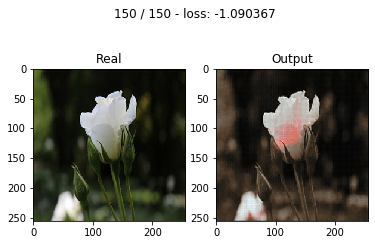

In [292]:
model_1 = UNet2_f().to(DEVICE)
model_2 = Simple_f().to(DEVICE)
optim_1 = optim.Adam(model_1.parameters(), lr=3e-3, weight_decay=0.001)
optim_2 = optim.Adam(model_2.parameters(), lr=3e-3, weight_decay=0.001)
train_2 = train(model_1, model_2, optim_1, optim_2, lossG, lossG, 150, train_data)

Для теста были выбраны 9 черно-белые фотографии, к которым пришлось применить .convert('LA'), чтобы число каналов было не 3, а 2

torch.Size([3, 256, 256]) 9


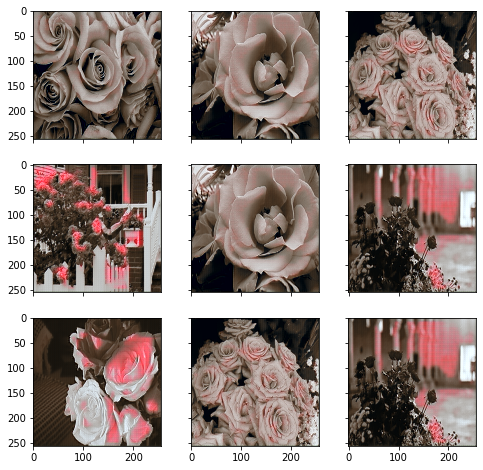

In [293]:
path = "Test/"
os.listdir(path)
for i in os.listdir(path):
    img = Image.open(path+i).convert('LA')
    img.save('te/'+i[:-3]+'png')
    
test_dir_baw = Path("te")
test_baw = sorted(list(test_dir_baw.rglob('*.png')))
test_f_baw = Dataset(test_baw)
test_data = DataLoader((test_f_baw), shuffle=False)
for i, num in enumerate(test_data):
    if i == 0:
        y_1 = model_1(num.to(DEVICE))
    else:
        y_pred = model_1(num.to(DEVICE))
        y_1 = torch.cat((y_1,y_pred), dim = 0)
print(y_1[0].shape, len(y_1))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,9))
    im_val = y_1[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

Новая loss функция с дисперсией

In [298]:
def lossG(y_predD, y_predG, Y_batch):
    y_predD_G = y_predD[:25]
    y_predD_D = y_predD[25:]
    mean = y_predG.mean([1, 2, 3])
    dis = ( - mean)
    loss = nn.L1Loss()
    output = loss(y_predG, Y_batch)
    res = 0.04*(torch.log(y_predD_D + 1e-8) + torch.log(1 - y_predD_G + 1e-8)).sum()+ 5 * output.sum()
    - ((y_predG - mean[:, None, None, None])**2).sum()/(28*256*256*3)
    return res

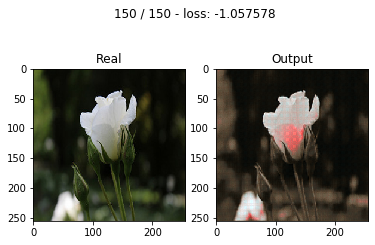

In [286]:
model_1 = UNet2_f().to(DEVICE)
model_2 = Simple_f().to(DEVICE)
optim_1 = optim.Adam(model_1.parameters(), lr=3e-3, weight_decay=0.001)
optim_2 = optim.Adam(model_2.parameters(), lr=3e-3, weight_decay=0.001)
train_3 = train(model_1, model_2, optim_1, optim_2, lossG, lossG, 150, train_data)

torch.Size([3, 256, 256]) 9


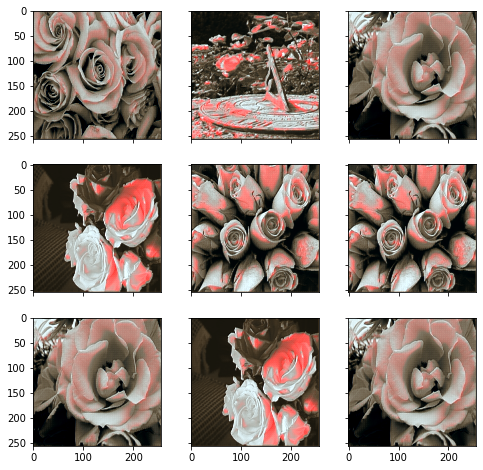

In [287]:
for i, num in enumerate(test_data):
    if i == 0:
        y_1 = model_1(num.to(DEVICE))
    else:
        y_pred = model_1(num.to(DEVICE))
        y_1 = torch.cat((y_1,y_pred), dim = 0)
print(y_1[0].shape, len(y_1))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,9))
    im_val = y_1[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

Интересно следующее, в основном модель генерирует на тесте изображение с добавлением розового (иногда оранжевого), поэтому pix2pix научился добавлять только 1 цвет с оттенками около этого цвета. Результат полученный с новой loss функцией лучше, а именно новый цвет лег естественнее, насыщеннее и по большей части розовый появлялся больше на цветах, где этот цвет и должен быть. Попробуем увеличить количество эпох

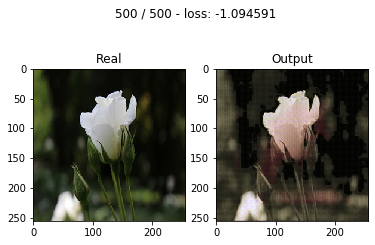

In [299]:
model_1 = UNet2_f().to(DEVICE)
model_2 = Simple_f().to(DEVICE)
optim_1 = optim.Adam(model_1.parameters(), lr=3e-3, weight_decay=0.001)
optim_2 = optim.Adam(model_2.parameters(), lr=3e-3, weight_decay=0.001)
train_3 = train(model_1, model_2, optim_1, optim_2, lossG, lossG, 500, train_data)

torch.Size([3, 256, 256]) 9


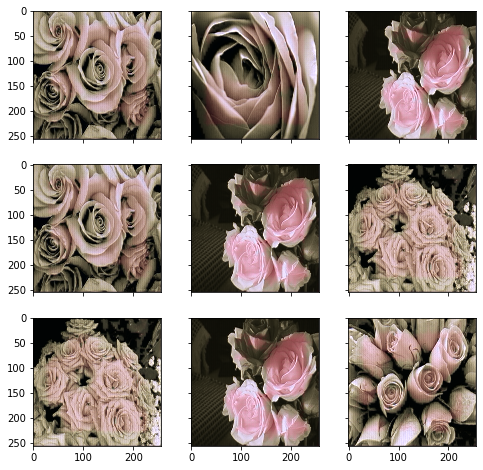

In [300]:
path = "Test/"
os.listdir(path)
for i in os.listdir(path):
    img = Image.open(path+i).convert('LA')
    img.save('te/'+i[:-3]+'png')
    
test_dir_baw = Path("te")
test_baw = sorted(list(test_dir_baw.rglob('*.png')))
test_f_baw = Dataset(test_baw)
test_data = DataLoader((test_f_baw), shuffle=False)
for i, num in enumerate(test_data):
    if i == 0:
        y_1 = model_1(num.to(DEVICE))
    else:
        y_pred = model_1(num.to(DEVICE))
        y_1 = torch.cat((y_1,y_pred), dim = 0)
print(y_1[0].shape, len(y_1))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,9))
    im_val = y_1[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)